<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_8_%EB%AA%A9(Q%26A_bAbi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

메로리 네트워크(Memory Network)를 이용한 QA
- Babi 데이터셋


In [ ]:
%cd '/content/drive/MyDrive/머신러닝/bAbiQA1'

/content/drive/MyDrive/머신러닝/bAbiQA1


In [ ]:
# -*- coding: utf-8 -*-
"""QnA(babi).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1H5Wjq_uhOmkYBGOqSJOoJXaR6bWyperF
"""

# Question & Answering problem : 관련 논문의 간단 & 변형 버전.
#
# 관련 논문 : [1] Sainbayar Sukhbaatar, et. al, 2015, End-To-End Memory Networks
# 코드 출처 : Krishna Bhavsar et. al., 2017, 
#            "Natural Language Processing with Python Cookbook"
#
# 코드 수정 : blog.naver.com/chunjein, 2021.04.12
#
# get_data() 함수에서 bAbi 데이터의 story 부분을 parsing할 때 일련의 episode를
# 보존하지 못한 부분을 수정했음. ID가 1로 reset되기 전까지는 하나의 episode임.
#
# 참고 사항 : 간단 버전이므로 bAbi의 'qa1_sigle_fact'는 어느 정도 분석하지만,
#            'qa2_two_facts'는 거의 분석하지 못한다. (정확도 = 30% 정도)
#             논문 [1]의 내용을 제대로 적용하면 정확도 = 90% 이상임.
# -------------------------------------------------------------------------------
import collections
import nltk
import numpy as np
from copy import deepcopy
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, Permute
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Add, Concatenate, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import random

nltk.download('punkt')

# Commented out IPython magic to ensure Python compatibility.
# %cd '/content/drive/MyDrive/Colab Notebooks'

#train_file = "data/qa1_single-supporting-fact_train.txt"
#test_file = "data/qa1_single-supporting-fact_test.txt"
# train_file = "data/qa2_two-supporting-facts_train.txt"
# test_file = "data/qa2_two-supporting-facts_test.txt"
train_file = '/content/drive/MyDrive/머신러닝/bAbiQA1/qa1_single-supporting-fact_train.txt'
test_file = '/content/drive/MyDrive/머신러닝/bAbiQA1/qa1_single-supporting-fact_test.txt'
# bAbi 데이터 parsing. 데이터 구조는 https://research.fb.com/downloads/babi/ 참조

# 함수 만들기
def get_data(infile, max_stories=30):
  # stories, questions, answers, stroy_text 만들기
    stories = []
    questions = []
    answers = []
    story_text = []
    fin = open(infile, "r")
    old_ID = 0
    for line in fin:
        # IDs(첫 번호), text(문자)
        # 첫 번째 나타나는 공백으로 나눈다. 
        IDs, text = line.split(" ", 1)
        IDs = int(IDs)
        #print(text)
        #print(IDs)
        if IDs < old_ID:     # ID reset
            story_text = []
           
        if "\t" in text:
            # shawllow copy : 똑같은 주석값을 공유하기 때문에 a라는 변수에 복사가 되어 b를 수정할 수 있다.
            # deep copy : 다른 주석값을 공유하기 때문에 a라는 변수의 값이 b로 변환해도 완전 다른 값이 된다. 
            s = deepcopy(story_text)
            
            # story sequence가 긴 경우는 88개까지 있다. 너무 길어서
            # max_stories 개수만큼으로 제한한다.
            # 현재 읽는 줄이 // 질문 (tab) 답변 (tab)인 경우
            if len(s) <= max_stories:
                question, answer, _ = text.split("\t")
                stories.append(s)
                questions.append(question)
                answers.append(answer)
                #print(question)
                #print(_)
        else: # 현재 읽는 줄이 스토리인 경우
            story_text.append(text.strip()) # 임시저장
        old_ID = IDs
        
    fin.close()
    return stories, questions, answers

#len(train_file) #78
#len(test_file) #77


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


77

In [ ]:
data_train = get_data(train_file, max_stories = 20)

In [ ]:
#f = open('/content/drive/MyDrive/머신러닝/bAbiQA1/qa1_single-supporting-fact_train.txt', 'r')
#lines = f.readlines()
#lines

In [ ]:
#f = open('/content/drive/MyDrive/머신러닝/bAbiQA1/qa1_single-supporting-fact_test.txt', 'r')
#lines = f.readlines()
#lines

In [ ]:
# bAbi 데이터를 parsing 한다.
data_train = get_data(train_file, max_stories = 20)
data_test = get_data(test_file, max_stories = 20)

data_train[0][0]

# 어휘 사전을 생성한다.
# collection.Counter() : 리스트의 요소개수를 구할 수 있고, 출력 결과는 딕셔너리형태로 반환하여 준다. 
vocab = collections.Counter()
for stories, questions, answers in [data_train, data_test]:
    # story 문장에 사용된 단어의 빈도를 파악한다.
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                vocab[word.lower()] += 1
    
    # question 문장에 사용된 단어의 빈도를 파악한다.
    for question in questions:
        for word in nltk.word_tokenize(question):
            vocab[word.lower()] += 1
    
    # answer에 사용된 단어의 빈도를 파악한다.
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            vocab[word.lower()] += 1


In [ ]:
# 빈도가 높은 것부터 어휘 사전에 등록한다. (등록 순서가 중요한 것은 아님)
word2idx = {w:(i+1) for i,(w,_) in enumerate(vocab.most_common())}
word2idx["<PAD>"] = 0   
vocab_size = len(word2idx)

# story, question 문장과 answer 단어를 수치 벡터로 변환한다.
def vectorize(data):
    x_story = []
    x_query = []
    y_answer = []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):       
        xs = [word2idx[w.lower()] for s in story for w in nltk.word_tokenize(s)]
        xq = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
        
        x_story.append(xs)
        x_query.append(xq)
        y_answer.append(word2idx[answer.lower()])
    
    return x_story, x_query, y_answer

xs_train_tok, xq_train_tok, y_train_tok = vectorize(data_train)
xs_test_tok, xq_test_tok, y_test_tok = vectorize(data_test)


In [ ]:
# padding을 위해 문장의 최대 길이를 파악한다.
story_max = 0
query_max = 0
for tokens in [xs_train_tok, xs_test_tok]:
    for tok in tokens:
        if len(tok) > story_max:
            story_max = len(tok)
            
for tokens in [xq_train_tok, xq_test_tok]:
    for tok in tokens:
        if len(tok) > query_max:
            query_max = len(tok)


# padding을 적용해서 학습 데이터를 생성한다.
xs_train = pad_sequences(xs_train_tok, maxlen=story_max)
xq_train = pad_sequences(xq_train_tok, maxlen=query_max)
xs_test = pad_sequences(xs_test_tok, maxlen=story_max)
xq_test = pad_sequences(xq_test_tok, maxlen=query_max)
y_train = np.array(y_train_tok)
y_test = np.array(y_test_tok)


In [ ]:
# Model을 생성한다.
EMB_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Inputs
story_input = Input(shape=(story_max,))
question_input = Input(shape=(query_max,))

# Story encoder embedding
story_encoder = Embedding(vocab_size, EMB_SIZE)(story_input)
story_encoder = Dropout(0.2)(story_encoder)

# Question encoder embedding
question_encoder = Embedding(vocab_size, EMB_SIZE)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

# Match between story and question
# 단거간의 유사도를 구한다. 
match = Dot(axes=[2, 2])([story_encoder, question_encoder])

# Encode story into vector space of question
story_encoder_c = Embedding(vocab_size, query_max)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)

# Combine match and story vectors
response = Add()([match, story_encoder_c])  
response = Permute((2, 1))(response)

# Combine response and question vectors to answers space
answer = Concatenate()([response, question_encoder])
answer = LSTM(LATENT_SIZE, dropout=0.2)(answer)
output = Dense(vocab_size, activation='softmax')(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 68, 128)      2816        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 4, 128)       2816        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Model Training
history = model.fit([xs_train, xq_train], [y_train],
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS,
                    validation_data=([xs_test, xq_test], [y_test]))


Epoch 1/40
157/157 [==============================] - 6s 23ms/step - loss: 1.9590 - val_loss: 1.7330
Epoch 2/40
157/157 [==============================] - 3s 19ms/step - loss: 1.6462 - val_loss: 1.5914
Epoch 3/40
157/157 [==============================] - 3s 19ms/step - loss: 1.5466 - val_loss: 1.4815
Epoch 4/40
157/157 [==============================] - 3s 20ms/step - loss: 1.4454 - val_loss: 1.4018
Epoch 5/40
157/157 [==============================] - 3s 20ms/step - loss: 1.3749 - val_loss: 1.3311
Epoch 6/40
157/157 [==============================] - 3s 20ms/step - loss: 1.3194 - val_loss: 1.2885
Epoch 7/40
157/157 [==============================] - 3s 19ms/step - loss: 1.2821 - val_loss: 1.2787
Epoch 8/40
157/157 [==============================] - 3s 19ms/step - loss: 1.2452 - val_loss: 1.2508
Epoch 9/40
157/157 [==============================] - 3s 19ms/step - loss: 1.2208 - val_loss: 1.2566
Epoch 10/40
157/157 [==============================] - 3s 19ms/step - loss: 1.1907 - val_lo

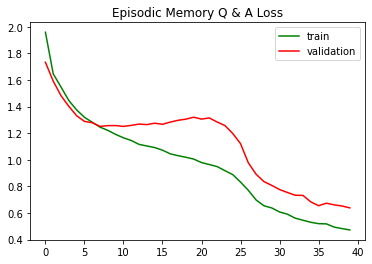

In [ ]:
# loss plot
plt.title("Episodic Memory Q & A Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="r", label="validation")
plt.legend(loc="best")
plt.show()


In [ ]:
# 정확도 평가
y_pred_p = model.predict([xs_test, xq_test])
y_pred = np.argmax(y_pred_p, axis=1)
accuracy = (y_test == y_pred).mean()

# test data와 prediction 결과를 확인한다. 샘플 10개만.
idx2word = {v:k for k, v in word2idx.items()}
for i in random.sample(range(xs_test.shape[0]), 10):
    story = data_test[0][i]
    question = data_test[1][i]
    answer = data_test[2][i]
    pred_ans = idx2word[y_pred[i]]
    
    print('\n i: {}'.format(i))
    
    for k in range(len(story)):
        print('S{}: {}'.format(k+1, story[k].strip()))
        
    print(' Q: {}'.format(question))
    print(' A: {}'.format(answer))    
    print(' P: {}, prob={:.3f}'.format(pred_ans, np.max(y_pred_p[i])))

print('정확도 = {:.4f} %'.format(100 * accuracy))



 i: 52
S1: John journeyed to the hallway.
S2: John journeyed to the bedroom.
S3: Daniel journeyed to the bedroom.
S4: John journeyed to the office.
S5: John moved to the garden.
S6: Daniel moved to the garden.
 Q: Where is John? 
 A: garden
 P: garden, prob=0.895

 i: 70
S1: Sandra journeyed to the bedroom.
S2: Mary journeyed to the garden.
 Q: Where is Mary? 
 A: garden
 P: garden, prob=0.999

 i: 719
S1: John journeyed to the bedroom.
S2: Sandra journeyed to the garden.
S3: Daniel went back to the hallway.
S4: Mary went to the hallway.
S5: Daniel travelled to the kitchen.
S6: Daniel went to the office.
S7: Daniel travelled to the bedroom.
S8: Sandra went to the office.
S9: Mary went back to the bathroom.
S10: Mary journeyed to the office.
 Q: Where is Sandra? 
 A: office
 P: hallway, prob=0.395

 i: 532
S1: Mary moved to the office.
S2: John moved to the garden.
S3: Sandra moved to the bedroom.
S4: Sandra went back to the office.
S5: John went to the bedroom.
S6: John journeyed to t